In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('filtered2_df.csv')

In [11]:
df.columns.values

array(['Unnamed: 0', 'Unnamed: 0.1', 'Season', 'Game_ID', 'PLAYER_NAME',
       'POS', 'Team', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA',
       'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'PLUS_MINUS', 'VIDEO_AVAILABLE', 'DD', 'TD',
       'total_fantasy_points'], dtype=object)

In [12]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# model 1

In [14]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# parameters
hidden_size = 128
num_layers = 3
output_size = 1
dropout_prob = 0.5

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size, dropout_prob)
criterion = nn.L1Loss()  # Change to Mean Absolute Error
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# training loop
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# store values
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # Update the learning rate
        scheduler.step(test_loss)
    
    # Append the loss and accuracy values to the corresponding lists
    train_losses.append(avg_epoch_loss)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)
    
    # train
    model.train()


Epoch [1/100], Average Loss: 7.8568
Epoch [1/100], Average Test Loss: 7.1960, Test Accuracy: 0.4831
Epoch [2/100], Average Loss: 7.4472
Epoch [2/100], Average Test Loss: 7.1931, Test Accuracy: 0.4920
Epoch [3/100], Average Loss: 6.6867
Epoch [3/100], Average Test Loss: 4.7587, Test Accuracy: 0.6996
Epoch [4/100], Average Loss: 5.1667
Epoch [4/100], Average Test Loss: 4.3193, Test Accuracy: 0.7282
Epoch [5/100], Average Loss: 5.0120
Epoch [5/100], Average Test Loss: 4.2804, Test Accuracy: 0.7329
Epoch [6/100], Average Loss: 4.8456
Epoch [6/100], Average Test Loss: 4.1319, Test Accuracy: 0.7488
Epoch [7/100], Average Loss: 4.8023
Epoch [7/100], Average Test Loss: 4.1005, Test Accuracy: 0.7512
Epoch [8/100], Average Loss: 4.6549
Epoch [8/100], Average Test Loss: 4.0847, Test Accuracy: 0.7484
Epoch [9/100], Average Loss: 4.6039
Epoch [9/100], Average Test Loss: 3.8567, Test Accuracy: 0.7624
Epoch [10/100], Average Loss: 4.5126
Epoch [10/100], Average Test Loss: 3.9376, Test Accuracy: 0.767

Epoch [76/100], Average Test Loss: 3.5285, Test Accuracy: 0.7826
Epoch [77/100], Average Loss: 3.5367
Epoch [77/100], Average Test Loss: 3.5291, Test Accuracy: 0.7835
Epoch [78/100], Average Loss: 3.5443
Epoch [78/100], Average Test Loss: 3.5295, Test Accuracy: 0.7830
Epoch [79/100], Average Loss: 3.4994
Epoch [79/100], Average Test Loss: 3.5296, Test Accuracy: 0.7840
Epoch [80/100], Average Loss: 3.5075
Epoch [80/100], Average Test Loss: 3.5301, Test Accuracy: 0.7835
Epoch 00080: reducing learning rate of group 0 to 9.7656e-07.
Epoch [81/100], Average Loss: 3.5062
Epoch [81/100], Average Test Loss: 3.5305, Test Accuracy: 0.7840
Epoch [82/100], Average Loss: 3.4962
Epoch [82/100], Average Test Loss: 3.5305, Test Accuracy: 0.7840
Epoch [83/100], Average Loss: 3.5168
Epoch [83/100], Average Test Loss: 3.5304, Test Accuracy: 0.7840
Epoch [84/100], Average Loss: 3.5093
Epoch [84/100], Average Test Loss: 3.5301, Test Accuracy: 0.7840
Epoch [85/100], Average Loss: 3.5340
Epoch [85/100], Aver

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 3.5297
R^2 Score: 0.6162


In [19]:
import matplotlib.pyplot as plt

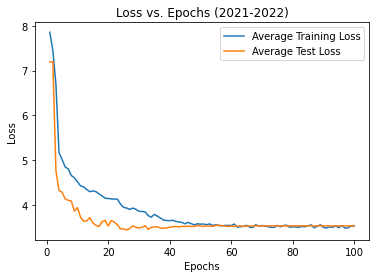

In [20]:
# Plot training and testing losses
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Average Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Average Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (2021-2022)')
plt.legend()
plt.show()

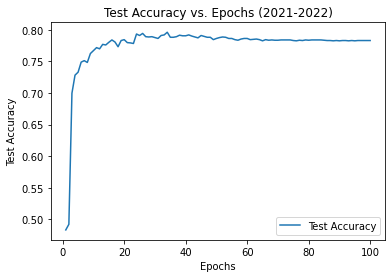

In [21]:
# Plot testing accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Epochs (2021-2022)')
plt.legend()
plt.show()

# model 2

In [ ]:
df = df[['PLAYER_NAME', 'POS', 'Team', 'GAME_DATE', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
       'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'PLUS_MINUS',
       'total_fantasy_points']]

# encode player positions
le = LabelEncoder()
df["POS"] = le.fit_transform(df["POS"])
df["Team"]= le.fit_transform(df["Team"])

# scale numerical features
numerical_features = ['MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT',
                      'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
                      'TOV', 'PF', 'PTS', 'PLUS_MINUS']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# sequences of games for each player
sequence_length = 50  # Set the number of past games to consider for each player
input_features = len(numerical_features) + 1  # Number of input features + position encoding
X = []
y = []

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:  # Check if the player has at least 50 games
        for i in range(len(player_data) - sequence_length):
            X.append(player_data.loc[i:i + sequence_length - 1, numerical_features + ['POS']].values)
            y.append(player_data.loc[i + sequence_length, 'total_fantasy_points'])

X = np.array(X)
y = np.array(y)


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# LSTM model 
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# parameters
hidden_size = 64
num_layers = 2
output_size = 1

# model, loss function, optimizer
model = LSTMModel(input_features, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
def regression_accuracy(y_true, y_pred, threshold=0.3):
    assert y_true.shape == y_pred.shape, "y_true and y_pred must have the same shape"
    within_threshold = torch.abs(y_true - y_pred) <= (threshold * y_true)
    accuracy = torch.mean(within_threshold.type(torch.float32))
    return accuracy.item()

In [9]:
num_epochs = 100
batch_size = 8
train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

for epoch in range(num_epochs):
    epoch_loss = 0
    n_batches = 0
    for i in range(0, len(train_tensor), batch_size):
        batch_X = train_tensor[i:i + batch_size]
        batch_y = y_train_tensor[i:i + batch_size]

        # forward
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        n_batches += 1

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # average loss for epoch
    avg_epoch_loss = epoch_loss / n_batches
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        test_loss = criterion(y_pred, y_test_tensor)
        test_accuracy = regression_accuracy(y_test_tensor, y_pred)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Test Loss: {test_loss.item():.4f}, Test Accuracy: {test_accuracy:.4f}')
    # train
    model.train()


Epoch [1/100], Average Loss: 280.5465
Epoch [1/100], Average Test Loss: 157.4014, Test Accuracy: 0.4556
Epoch [2/100], Average Loss: 129.8602
Epoch [2/100], Average Test Loss: 129.5764, Test Accuracy: 0.4556
Epoch [3/100], Average Loss: 122.3947
Epoch [3/100], Average Test Loss: 128.8477, Test Accuracy: 0.4458
Epoch [4/100], Average Loss: 122.3301
Epoch [4/100], Average Test Loss: 128.7806, Test Accuracy: 0.4458
Epoch [5/100], Average Loss: 102.4673
Epoch [5/100], Average Test Loss: 77.0845, Test Accuracy: 0.6844
Epoch [6/100], Average Loss: 64.2551
Epoch [6/100], Average Test Loss: 59.9792, Test Accuracy: 0.7140
Epoch [7/100], Average Loss: 52.9698
Epoch [7/100], Average Test Loss: 53.8908, Test Accuracy: 0.7278
Epoch [8/100], Average Loss: 46.3377
Epoch [8/100], Average Test Loss: 49.3219, Test Accuracy: 0.7535
Epoch [9/100], Average Loss: 42.6789
Epoch [9/100], Average Test Loss: 46.9387, Test Accuracy: 0.7594
Epoch [10/100], Average Loss: 39.0522
Epoch [10/100], Average Test Loss: 

Epoch [81/100], Average Loss: 1.6583
Epoch [81/100], Average Test Loss: 50.5410, Test Accuracy: 0.7456
Epoch [82/100], Average Loss: 1.7533
Epoch [82/100], Average Test Loss: 49.1530, Test Accuracy: 0.7495
Epoch [83/100], Average Loss: 2.2276
Epoch [83/100], Average Test Loss: 52.2982, Test Accuracy: 0.7061
Epoch [84/100], Average Loss: 1.8846
Epoch [84/100], Average Test Loss: 48.1783, Test Accuracy: 0.7495
Epoch [85/100], Average Loss: 1.5289
Epoch [85/100], Average Test Loss: 50.6996, Test Accuracy: 0.7258
Epoch [86/100], Average Loss: 1.3653
Epoch [86/100], Average Test Loss: 50.7758, Test Accuracy: 0.7318
Epoch [87/100], Average Loss: 1.2027
Epoch [87/100], Average Test Loss: 50.3698, Test Accuracy: 0.7298
Epoch [88/100], Average Loss: 1.1608
Epoch [88/100], Average Test Loss: 50.3150, Test Accuracy: 0.7199
Epoch [89/100], Average Loss: 1.1875
Epoch [89/100], Average Test Loss: 48.9649, Test Accuracy: 0.7337
Epoch [90/100], Average Loss: 1.2829
Epoch [90/100], Average Test Loss: 4

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 4.5834
R^2 Score: 0.6585


## Now that we have trained the LSTM model, let us construct a function that predicts the total fantasy points that each player will generate for their next future game. 

In [22]:
sequence_length = 50

player_names_50 = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
    if len(player_data) >= sequence_length:
        player_names_50.append(player_name)

player_names_50 

['Aaron Gordon',
 'Aaron Holiday',
 'Aaron Nesmith',
 'Aaron Wiggins',
 'Al Horford',
 'Alec Burks',
 'Aleksej Pokusevski',
 'Amir Coffey',
 'Andre Drummond',
 'Andrew Wiggins',
 'Anfernee Simons',
 'Anthony Edwards',
 'Austin Reaves',
 'Austin Rivers',
 'Ayo Dosunmu',
 'Bam Adebayo',
 'Blake Griffin',
 'Bobby Portis',
 'Bones Hyland',
 'Brandon Clarke',
 'Brandon Ingram',
 'Bruce Brown',
 'Bruno Fernando',
 'Bryn Forbes',
 'Buddy Hield',
 'CJ McCollum',
 'Cade Cunningham',
 'Caleb Martin',
 'Cam Reddish',
 'Cam Thomas',
 'Cameron Johnson',
 'Cameron Payne',
 'Caris LeVert',
 'Cedi Osman',
 'Chimezie Metu',
 'Chris Boucher',
 'Chris Duarte',
 'Chris Paul',
 'Christian Wood',
 'Chuma Okeke',
 'Clint Capela',
 'Coby White',
 'Cody Martin',
 'Cole Anthony',
 'Corey Kispert',
 'Cory Joseph',
 "D'Angelo Russell",
 'Dalano Banton',
 'Damian Jones',
 'Damion Lee',
 'Daniel Gafford',
 'Danny Green',
 'Darius Bazley',
 'Darius Garland',
 'Davion Mitchell',
 'Davon Reed',
 "De'Aaron Fox",
 "De'A

In [23]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,75
1,Aaron Holiday,63
2,Aaron Nesmith,52
3,Aaron Wiggins,50
4,Admiral Schofield,38
...,...,...
404,Ryan Arcidiacono,30
405,Terry Taylor,99
406,Thomas Bryant,81
407,Victor Oladipo,8


In [24]:
filtered_df = seq_lengths_df[seq_lengths_df['SEQ_LENGTH'] >= 50]
print(filtered_df)

         PLAYER_NAME  SEQ_LENGTH
0       Aaron Gordon          75
1      Aaron Holiday          63
2      Aaron Nesmith          52
3      Aaron Wiggins          50
5         Al Horford          69
..               ...         ...
389  Ziaire Williams          62
396     Kyrie Irving          87
403    Rui Hachimura         126
405     Terry Taylor          99
406    Thomas Bryant          81

[270 rows x 2 columns]


In [25]:
player_name = 'Aaron Gordon'
player_points_sequence = df.loc[df['PLAYER_NAME'] == player_name, 'total_fantasy_points'].tolist()
player_points_sequence

[19.5,
 18.75,
 12.5,
 26.0,
 23.0,
 30.75,
 17.25,
 32.5,
 36.25,
 17.0,
 21.25,
 14.75,
 33.5,
 22.75,
 22.25,
 19.25,
 15.25,
 24.5,
 23.25,
 25.75,
 21.25,
 13.75,
 26.5,
 18.0,
 26.5,
 20.75,
 25.0,
 18.0,
 20.0,
 27.0,
 28.0,
 19.5,
 21.0,
 21.5,
 29.25,
 17.5,
 34.75,
 31.5,
 17.25,
 31.0,
 27.0,
 24.75,
 14.5,
 27.25,
 35.0,
 26.5,
 31.5,
 36.75,
 19.75,
 15.5,
 29.5,
 12.0,
 29.75,
 21.0,
 19.75,
 16.25,
 25.25,
 26.25,
 16.25,
 18.25,
 16.0,
 30.5,
 23.0,
 32.75,
 29.0,
 19.5,
 23.75,
 15.5,
 25.25,
 33.25,
 27.75,
 19.75,
 13.75,
 17.75,
 31.0]

## example of one player's predicted total fantasy points for their next game

In [26]:
# MODEL 1
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 4.84


In [14]:
# MODEL 2
# drop na values
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

# most recent sequence of games
player_name = 'Alex Len'
player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)

# player max sequence length from seq_lengths_df
sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
last_sequence = player_data.iloc[-sequence_length:, :]

# numerical features scaled
last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])

# convert to tensor and predict future total fantasy points for next game
with torch.no_grad():
    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                dtype=torch.float32)
    pred = model(input_tensor).item()
    print(f'Predicted total fantasy points for {player_name} in the next game: {pred:.2f}')


Predicted total fantasy points for Alex Len in the next game: 5.08


# sequence length for all games

In [27]:
seq_lengths = []
for player_name in df['PLAYER_NAME'].unique():
    player_data = df[df['PLAYER_NAME'] == player_name]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
seq_lengths_df = pd.DataFrame(seq_lengths)
seq_lengths_df
seq_lengths_df = seq_lengths_df[(seq_lengths_df != 0).all(1)].dropna()

In [28]:
seq_lengths_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,75
1,Aaron Holiday,63
2,Aaron Nesmith,52
3,Aaron Wiggins,50
4,Admiral Schofield,38
...,...,...
404,Ryan Arcidiacono,30
405,Terry Taylor,99
406,Thomas Bryant,81
407,Victor Oladipo,8


# sequence length with cutoff date

In [31]:
seq_lengths = []
cutoff_date = '2022-03-10'  # Specify the cutoff date as a string in the format 'YYYY-MM-DD'

for player_name in df['PLAYER_NAME'].unique():
    player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
    seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
seq_lengths_cut_df = pd.DataFrame(seq_lengths)
seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)


In [32]:
seq_lengths_cut_df

,PLAYER_NAME,SEQ_LENGTH
0,Aaron Gordon,61
1,Aaron Holiday,51
2,Aaron Nesmith,45
3,Aaron Wiggins,40
4,Admiral Schofield,29
...,...,...
404,Ryan Arcidiacono,12
405,Terry Taylor,57
406,Thomas Bryant,60
407,Victor Oladipo,2


## function that predicts all players total fantasy points for their next game

In [33]:
# FOR MODEL 1
def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df_1 = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df_1)


           PLAYER_NAME  PRED_SCORE
0         Aaron Gordon    7.121541
1        Aaron Holiday    7.711138
2        Aaron Nesmith    4.717971
3        Aaron Wiggins    6.481066
4    Admiral Schofield    4.177202
..                 ...         ...
404   Ryan Arcidiacono    4.946707
405       Terry Taylor    5.745700
406      Thomas Bryant    7.429140
407     Victor Oladipo   16.571228
408       Zach Collins    4.720211

[409 rows x 2 columns]


In [34]:
filtered2_prediction = player_predictions_df_1
print(filtered2_prediction)
filtered2_prediction.to_csv('filtered2_prediction.csv')

           PLAYER_NAME  PRED_SCORE
0         Aaron Gordon    7.121541
1        Aaron Holiday    7.711138
2        Aaron Nesmith    4.717971
3        Aaron Wiggins    6.481066
4    Admiral Schofield    4.177202
..                 ...         ...
404   Ryan Arcidiacono    4.946707
405       Terry Taylor    5.745700
406      Thomas Bryant    7.429140
407     Victor Oladipo   16.571228
408       Zach Collins    4.720211

[409 rows x 2 columns]


In [116]:
# FOR MODEL 2

def predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[df['PLAYER_NAME'] == player_name].reset_index(drop=True)
        
        if not player_data.empty:
            sequence_length = seq_lengths_df.loc[seq_lengths_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH'].item()
            last_sequence = player_data.iloc[-sequence_length:, :]
            last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
            
            
            with torch.no_grad():
                input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                            dtype=torch.float32)
                pred = model(input_tensor).item()
                
            player_names.append(player_name)
            predicted_scores.append(pred)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


unique_players = df['PLAYER_NAME'].unique()


player_predictions_df = predict_next_game_scores(df, seq_lengths_df, numerical_features, input_features, scaler, model, unique_players)


print(player_predictions_df)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   32.825794
1            Alec Burks   11.400746
2    Aleksej Pokusevski   28.215349
3              Alex Len   21.400585
4           Amir Coffey   19.255781
..                  ...         ...
255       Trent Forrest    7.102448
256      Troy Brown Jr.    9.768965
257           Ty Jerome   20.372927
258       Udonis Haslem    4.084120
259         Will Barton   17.657267

[260 rows x 2 columns]


In [117]:
num_unique_names = len(df['PLAYER_NAME'].unique())
print(num_unique_names)


260


# with cutoff

In [21]:
def get_seq_lengths_cut(df, cutoff_date):
    seq_lengths = []
    for player_name in df['PLAYER_NAME'].unique():
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)]
        seq_lengths.append({'PLAYER_NAME': player_name, 'SEQ_LENGTH': len(player_data)})
    
    seq_lengths_cut_df = pd.DataFrame(seq_lengths)
    seq_lengths_cut_df = seq_lengths_cut_df[(seq_lengths_cut_df != 0).all(1)].dropna()
    seq_lengths_cut_df.drop_duplicates(subset=['PLAYER_NAME'], keep='first', inplace=True)
    return seq_lengths_cut_df


In [22]:
# MODEL 1
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df_1 = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df_1 = predictions_df_1.dropna()
    return predictions_df_1


In [23]:
cutoff_date = '2021-01-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_1 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_1)

Empty DataFrame
Columns: [PLAYER_NAME, PRED_SCORE]
Index: []


In [24]:
cutoff_date = '2023-04-07'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

        PLAYER_NAME  PRED_SCORE
0        A.J. Green    4.688403
1       A.J. Lawson    4.444252
2        AJ Griffin    6.383202
3      Aaron Gordon    4.791063
4     Aaron Holiday    6.183745
..              ...         ...
497     Skylar Mays    7.279849
498   Stanley Umude    4.753389
499  Sterling Brown    4.929890
500     Xavier Moon    5.178722
501    Xavier Sneed    5.500510

[502 rows x 2 columns]


In [33]:
merged_df = pd.merge(predictions_df_2, player_predictions_df_1, on='PLAYER_NAME', how='left', suffixes=('_cutoff', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE_cutoff,PRED_SCORE_all
0,Aaron Gordon,31.086620,28.816442
1,Alec Burks,12.697834,13.172770
2,Aleksej Pokusevski,26.607195,23.269098
3,Alex Len,27.945639,22.750591
4,Amir Coffey,26.126450,24.539713
...,...,...,...
251,Torrey Craig,25.653378,15.682243
252,Trent Forrest,8.375336,8.124166
253,Troy Brown Jr.,10.553717,13.297253
254,Ty Jerome,21.796755,19.744389


In [70]:
# MODEL 2
def predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date):
    player_names = []
    predicted_scores = []
    
    for player_name in unique_players:
        player_data = df[(df['PLAYER_NAME'] == player_name) & (df['GAME_DATE'] < cutoff_date)].reset_index(drop=True)
        
        seq_length = seq_lengths_cut_df.loc[seq_lengths_cut_df['PLAYER_NAME'] == player_name, 'SEQ_LENGTH']
        
        if not seq_length.empty:
            seq_length = seq_length.item()
            if len(player_data) >= seq_length:
                last_sequence = player_data.iloc[-seq_length:, :]
                last_sequence[numerical_features] = scaler.transform(last_sequence[numerical_features])
                
                with torch.no_grad():
                    input_tensor = torch.tensor(last_sequence[numerical_features + ['POS']].values.reshape(1, -1, input_features),
                                                dtype=torch.float32)
                    pred = model(input_tensor).item()

                player_names.append(player_name)
                predicted_scores.append(pred)
            else:
                player_names.append(player_name)
                predicted_scores.append(None)
        else:
            player_names.append(player_name)
            predicted_scores.append(None)

    predictions_df = pd.DataFrame({'PLAYER_NAME': player_names, 'PRED_SCORE': predicted_scores})
    predictions_df = predictions_df.dropna()
    return predictions_df


In [131]:
cutoff_date = '2021-01-16'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df)


            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [134]:
cutoff_date = '2021-05-01'
seq_lengths_cut_df = get_seq_lengths_cut(df, cutoff_date)

unique_players = df['PLAYER_NAME'].unique()

predictions_df_2 = predict_next_game_scores(df, seq_lengths_cut_df, numerical_features, input_features, scaler, model, unique_players, cutoff_date)

print(predictions_df_2)

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   32.334389
1            Alec Burks   14.217628
2    Aleksej Pokusevski   18.038410
3              Alex Len   18.154522
4           Amir Coffey   17.964472
..                  ...         ...
254        Torrey Craig   20.476349
255       Trent Forrest    8.772673
256      Troy Brown Jr.   10.206540
257           Ty Jerome   23.073565
259         Will Barton   20.324869

[256 rows x 2 columns]


# save predictions

In [25]:
# cutoff 4/7/23
filtered1_prediction_cutoff_2 = predictions_df_2
print(filtered1_prediction_cutoff_2)
filtered1_prediction_cutoff_2.to_csv('filtered1_prediction_cutoff_4_7.csv')

        PLAYER_NAME  PRED_SCORE
0        A.J. Green    4.688403
1       A.J. Lawson    4.444252
2        AJ Griffin    6.383202
3      Aaron Gordon    4.791063
4     Aaron Holiday    6.183745
..              ...         ...
497     Skylar Mays    7.279849
498   Stanley Umude    4.753389
499  Sterling Brown    4.929890
500     Xavier Moon    5.178722
501    Xavier Sneed    5.500510

[502 rows x 2 columns]


In [136]:
# cutoff 1/16
filtered3_prediction_cutoff_1_16 = predictions_df
print(filtered3_prediction_cutoff_1_16)
filtered3_prediction_cutoff_1_16.to_csv('filtered3_prediction_cutoff_1_16.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon   26.337820
1            Alec Burks   24.948862
2    Aleksej Pokusevski   13.125382
3              Alex Len    7.247935
4           Amir Coffey    7.595329
..                  ...         ...
245           Paul Reed    5.360580
248     Rodney McGruder    2.466958
249            Rudy Gay   11.046699
250           Saben Lee   11.982996
255       Trent Forrest    3.777227

[188 rows x 2 columns]


In [79]:
merged_df = pd.merge(predictions_df_2, player_predictions_df, on='PLAYER_NAME', how='left', suffixes=('_cutoff', '_all'))
merged_df

,PLAYER_NAME,PRED_SCORE_cutoff,PRED_SCORE_all
0,Aaron Gordon,6.828502,6.828502
1,Alec Burks,3.688114,3.671882
2,Aleksej Pokusevski,7.920433,7.157177
3,Alex Len,5.090460,5.077754
4,Amir Coffey,6.854105,6.854105
...,...,...,...
251,Torrey Craig,7.089234,5.211455
252,Trent Forrest,3.776723,3.814262
253,Troy Brown Jr.,4.665051,4.665051
254,Ty Jerome,8.067554,8.067554


In [75]:
filtered3_prediction = player_predictions_df
print(filtered3_prediction)
filtered3_prediction.to_csv('filtered3_prediction.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.828502
1            Alec Burks    3.671882
2    Aleksej Pokusevski    7.157177
3              Alex Len    5.077754
4           Amir Coffey    6.854105
..                  ...         ...
255       Trent Forrest    3.814262
256      Troy Brown Jr.    4.665051
257           Ty Jerome    8.067554
258       Udonis Haslem    5.428856
259         Will Barton    7.044220

[260 rows x 2 columns]


In [74]:
filtered3_prediction_cutoff = predictions_df
print(filtered3_prediction_cutoff)
filtered3_prediction_cutoff.to_csv('filtered3_prediction_cutoff.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.742910
1            Alec Burks   14.621668
2    Aleksej Pokusevski    3.595482
3              Alex Len    4.216353
4           Amir Coffey    2.831221
..                  ...         ...
245           Paul Reed    4.927056
248     Rodney McGruder    9.484635
249            Rudy Gay    4.352524
250           Saben Lee    4.741954
255       Trent Forrest    3.499499

[188 rows x 2 columns]


In [80]:
filtered3_prediction_cutoff_2 = predictions_df_2
print(filtered3_prediction_cutoff_2)
filtered3_prediction_cutoff_2.to_csv('filtered3_prediction_cutoff_2.csv')

            PLAYER_NAME  PRED_SCORE
0          Aaron Gordon    6.828502
1            Alec Burks    3.688114
2    Aleksej Pokusevski    7.920433
3              Alex Len    5.090460
4           Amir Coffey    6.854105
..                  ...         ...
254        Torrey Craig    7.089234
255       Trent Forrest    3.776723
256      Troy Brown Jr.    4.665051
257           Ty Jerome    8.067554
259         Will Barton    7.044220

[256 rows x 2 columns]
